# Topic: Data Mining - Recommendation Systems
## Part 2: NLA Approach - SVD




In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np #matrix handling
import pandas as pd#dataframe handling
from PIL import Image#Display the Image from the response request
import random
from io import StringIO, BytesIO
import requests #for generating re
from numpy.linalg import svd
import os
import sys
from io import StringIO, BytesIO
import requests
import matplotlib.pyplot as plt
import logging
from IPython.display import display
from collections import defaultdict
from sklearn import metrics
from surprise.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
from surprise import SVD, Reader, Dataset #For Matrix Factorization Model Training
from surprise.model_selection import train_test_split, cross_validate 
from surprise.model_selection import LeaveOneOut #required for hit rate calculation
from surprise import KNNBaseline 
import itertools

#**1.Preprocessing**



In [4]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy

--2022-12-09 12:36:43--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy [following]
--2022-12-09 12:36:43--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3502475168 (3.3G)
Saving to: ‘AmazonFashion6ImgPartitioned.npy.1’

      AmazonFashion  39%[======>             ]   1.27G  7.61MB/s    eta 3m 41s ^C


In [4]:
dataset = np.load("AmazonFashion6ImgPartitioned.npy", encoding="bytes",allow_pickle=True)
[interaction_data, _, _, items, user_num, item_num] = dataset

In [5]:
#convert json format to dataframes for easier processing and handling
dataset= []
for i in range(user_num):
  for j in interaction_data[i]:
    dataset.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])
df_interaction = pd.DataFrame(dataset, columns =['user', 'item','rating','ReviewTime','ReviewText'])
df_interaction.head()

,user,item,rating,ReviewTime,ReviewText
0,A1JWX45KHE34AL,B00APT3MHO,5.0,1384646400,Good for someone who likes skinny jeans but do...
1,A1JWX45KHE34AL,B00CJ5NH36,5.0,1384646400,This shirt with it's bold graphic is seriously...
2,A1JWX45KHE34AL,B00F9NGAPM,3.0,1384646400,The shirt is a little flowy-er than I expected...
3,A2YHF6O2D37PMX,B000LYFF46,3.0,1393804800,"I selected &#34;fit as expected&#34;, but they..."
4,A2YHF6O2D37PMX,B005FPAC8K,1.0,1336348800,May 27: I've worn them 3-4 times each since M...


In [6]:
#repeat for the metadata
items_interact = []
for i in range(len(items)):
  item_i = items[i][b'asin'].decode("utf-8") #get the item id
  if b'title' in items[i]:
    title_i = items[i][b'title'].decode("utf-8") #get the title
  else:
    title_i = "NA"
  if b'imUrl' in items[i]: #get the image URL
    img_i = items[i][b'imUrl']
  else:
    img_i = "NA"
  #price = items[i][b'price'].decode("utf-8")
  items_interact.append([item_i,title_i, img_i])
items_df = pd.DataFrame(items_interact, columns =['item', 'title','img'])
items_df.head()

,item,title,img
0,B008986OXM,"Cheap Monday Women's Tight Fit Jean, Hard Coat...",b'http://ecx.images-amazon.com/images/I/31bmhq...
1,B00APT3MHO,Cheap Monday Women's Skinny Tight Jean,b'http://ecx.images-amazon.com/images/I/31hFOd...
2,B00CJ5NH36,ELLAZHU Women Crew Neck Crane &amp; Fox Short ...,b'http://ecx.images-amazon.com/images/I/41-ZK3...
3,B00CP11HK4,ELLAZHU Women Geometrical Designs 3/4 Sleeve C...,b'http://ecx.images-amazon.com/images/I/51l0gD...
4,B00F9NGAPM,ELLAZHU Women Baggy Diagonal Stripes Long Slee...,b'http://ecx.images-amazon.com/images/I/41bWE1...


* Retain only active users and items (Users and Items with atleast 5 interactions)

In [7]:
user_count = df_interaction[["user","item"]].groupby("user").count()
usercount = user_count[user_count["item"] >= 7] #users with item interactions >=5
item_count = df_interaction[["user","item"]].groupby("item").count() #items with user interactions >=5
itemcount = item_count[item_count["user"] >= 7]

In [8]:
df_updated = df_interaction[df_interaction["user"].isin(usercount.index)\
                            & df_interaction["item"].isin(itemcount.index)]

##2. SVD Implementation to get n most similar items to an input item

In [9]:
reviewmatrix = df_updated.pivot(index="user", columns="item", values="rating").fillna(0) #create the pivot table for the interaction data
#imputated with 0 
matrix = reviewmatrix.values
u, s, vh = svd(matrix, full_matrices=False) #run svd

In [10]:
reviewmatrix.head()

item,B00006XXGO,B00009ZM7Z,B0000A4ZJD,B0000ANDU4,B0000AT7N2,B0000ATP8L,B0000BW6IN,B0000C321X,B0000DCS5T,B0000DYKET,...,B00J54ZCA0,B00J8IDFU2,B00J9CTDGM,B00JBYKENE,B00JDPRJAM,B00JDU6W5A,B00JEL60OG,B00JG4SU80,B00JGU2ZEE,B00JX59WZW
user,,,,,,,,,,,,,,,,,,,,,
A00146182PNM90WNNAZ5Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00404823GU1Q517KP4Z8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02155413BVL8D0G7X6DN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A022899328A0QROR32DCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A03140201UOOYZJMMJOFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
column = list(reviewmatrix.columns) #list of column names (items)
rows = list(reviewmatrix.T.columns) #list of row names (users)

In [12]:
def cosine_similarity(v,u):
  '''function to compute cosin similarity'''
  return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))





## Now let's visually verify the working of the recommender before we move on to metric based **comparison**


#### Example 1

In [13]:
item = column[0]
similarities = {}
for i in range(1,len(column)):
  #print(cosine_similarity(vh[:,0],vh[:,i]))
  similarities[column[i]]=cosine_similarity(vh[:,0],vh[:,i]) #get the similarity of the input item wrt all the other items

In [14]:
top_n = dict(sorted(similarities.items(), key=lambda item: item[1])[:10])

In [15]:
top_n

{'B0006LMBJ6': -4.996003610813205e-16,
 'B0015A6WKQ': -3.4694469519536167e-16,
 'B009RA63GO': -3.4694469519536167e-16,
 'B002KMI7OC': -3.356689926015123e-16,
 'B000B8P7Y0': -3.053113317719182e-16,
 'B00CN47GXA': -2.4286128663675314e-16,
 'B00374FWC2': -2.3592239273284586e-16,
 'B0018P3G3Y': -1.9775847626135618e-16,
 'B000EX15NY': -1.804112415015881e-16,
 'B004EVKJXO': -1.8041124150158809e-16}

* Very low similarity scores because of the sparsity despite the processing step

In [16]:
def disp_img(link, title):
  '''Function to display the images of the output'''
  response = requests.get(link)
  print(title)
  if str(response) == '<Response [200]>':
      img = Image.open(BytesIO(response.content))
      display(img)
  #print(response)
  #img = Image.open(BytesIO(response.content))
  #display(img)

["Merrell Men's Jungle Moc Slip-On Shoe"]


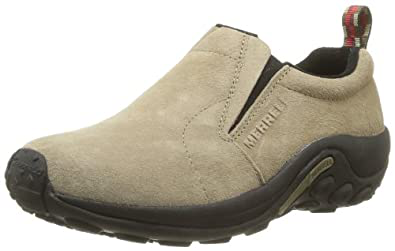

In [17]:
#get the image output and the title of the input item
item_0_link = list(items_df[items_df['item']==column[1]]['img'])[0]
item_0_title = list(items_df[items_df['item']==column[1]]['title'])
disp_img(item_0_link,item_0_title)

4497    Levi's Men's 511 Slim Fit Jean
Name: title, dtype: object


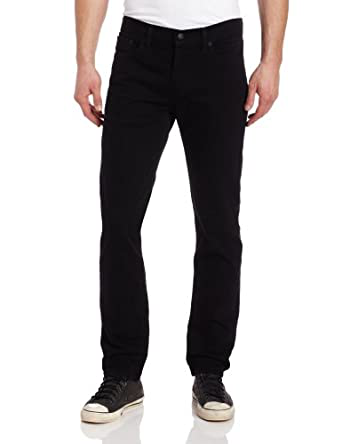

3372    Levi's Juniors 535 Legging Jean
Name: title, dtype: object


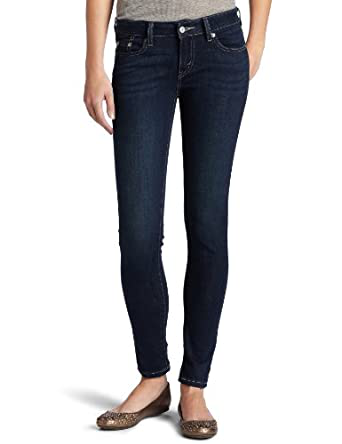

1076    Doublju Womens Knit Tunics with Unbalanced Hem...
Name: title, dtype: object


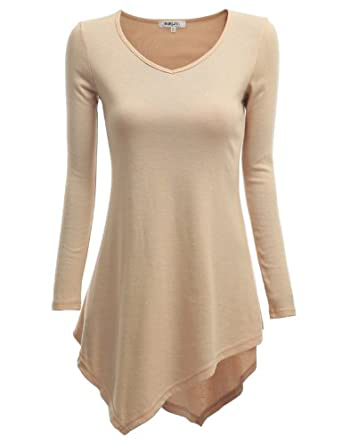

856    Teva Women's Tirra Athletic Sandal
Name: title, dtype: object


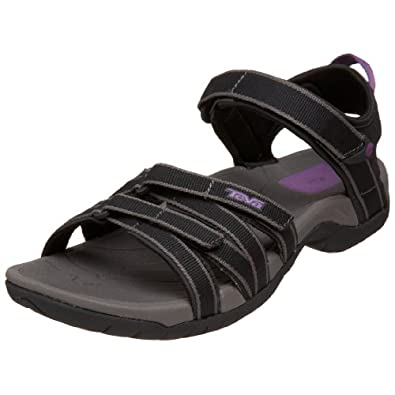

52    UGG Women's Classic Short Boot
Name: title, dtype: object


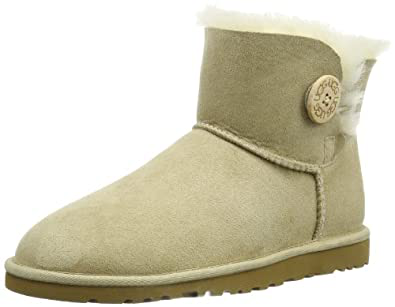

1109    Ladies Scoop Neck Stretchy Long Sleeve Knitted...
Name: title, dtype: object


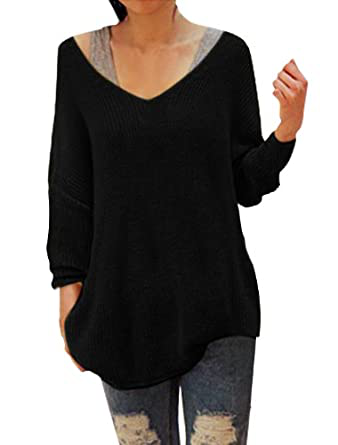

4068    Knee Length Pleated A-Line Skirt with Skinny Belt
Name: title, dtype: object


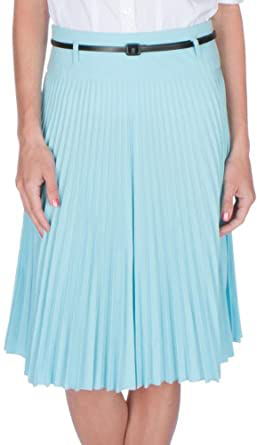

10387    Levi's Women's 529 Curvy Boot Cut Jean
Name: title, dtype: object


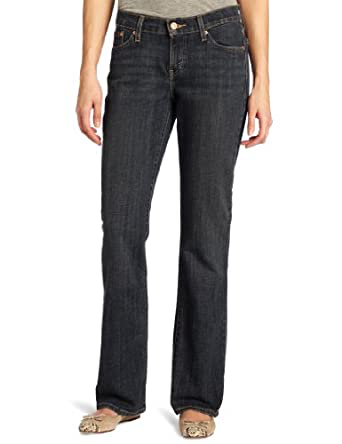

3744    Teva Women's Olowahu Sandal
Name: title, dtype: object


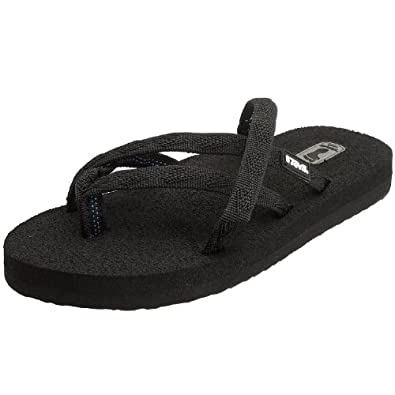

569    Lucky Women's Emmie Ballet Flat
Name: title, dtype: object


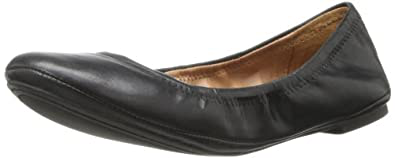

In [18]:
#get the image and the title of the remaining items
for i,_ in top_n.items():
  disp_img(list(items_df[items_df['item']==i]['img'])[0],items_df[items_df['item']==i]['title'])

#### Example 2

In [19]:
similarities = {}
for i in range(0,len(column)):
  if i!=2007:
    similarities[column[i]]=cosine_similarity(vh[:,2007],vh[:,i])#get the similarity of the input item wrt all the other items
top_n = dict(sorted(similarities.items(), key=lambda item: item[1])[:10])#get top n

68419    Naughty Monkey Women's Ice Stone Pump
Name: title, dtype: object


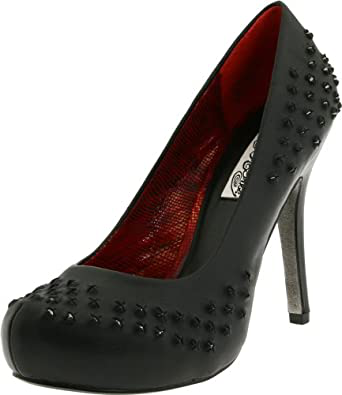

In [20]:
#display the input item
item_1_link = list(items_df[items_df['item']==column[2007]]['img'])[0]
item_1_title = items_df[items_df['item']==column[2007]]['title']
disp_img(item_1_link,item_1_title)

14978    Zehui Women's Chiffon Vogue Boho Evening Long ...
Name: title, dtype: object


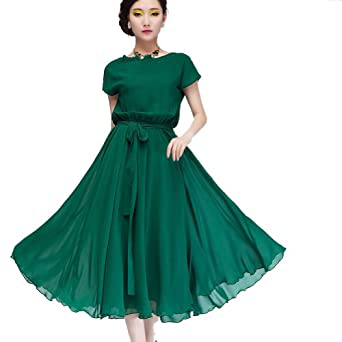

6    Easy Street Women's Masque Slingback Sandal
Name: title, dtype: object


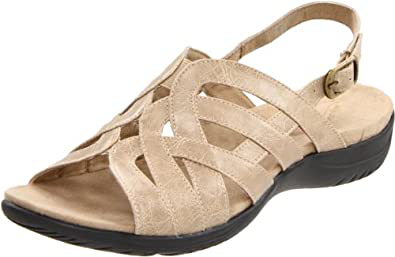

43568    Birkenstock Women's Florida Soft Footbed Sandal
Name: title, dtype: object


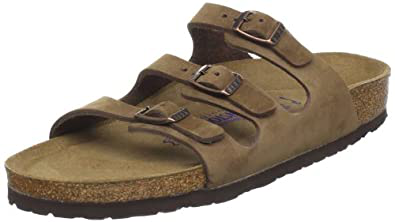

49384    MIA 2 Women's Brittany Ballet Flat
Name: title, dtype: object


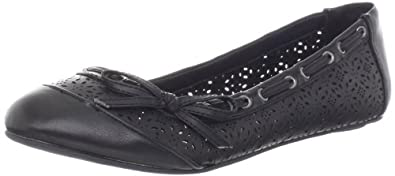

7039    DV by Dolce Vita Women's Ayden Sandal
Name: title, dtype: object


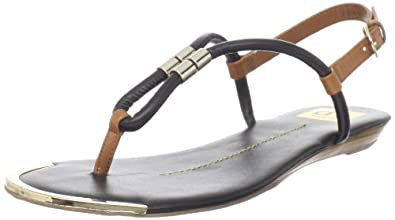

26290    Skechers Women's Tredds Interactive Oxford Sne...
Name: title, dtype: object


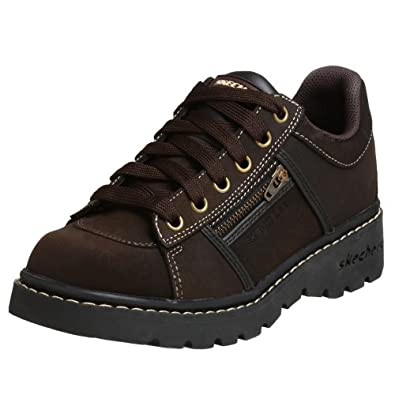

17591    PaperMoon Women's Plus Size Crochet Knitted Sh...
Name: title, dtype: object


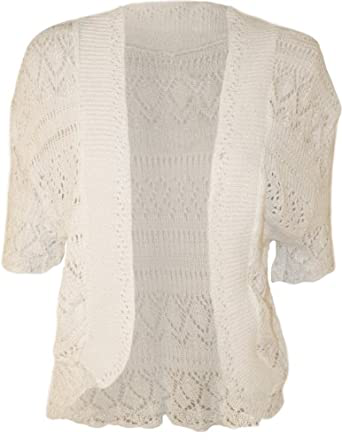

3193    Allegra K Women Plaids Single Breasted Flap Bu...
Name: title, dtype: object


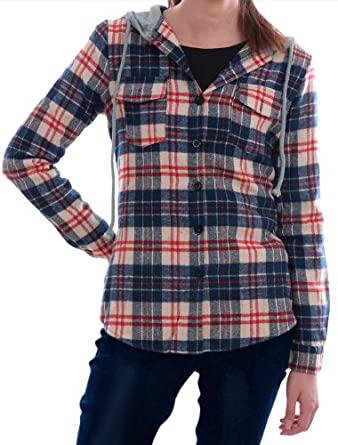

13701    Harvard Square Women's Five-Star Performance T...
Name: title, dtype: object


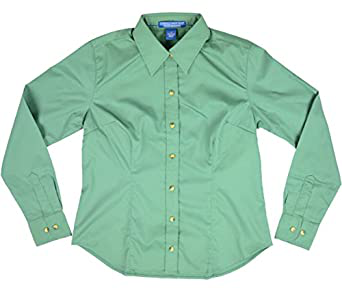

16    Jackson Amazon.com Exclusive Boys 8-20 Slim Fi...
Name: title, dtype: object


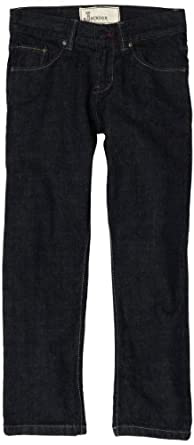

In [21]:
#get the image and the title of the remaining items
for i,_ in top_n.items():
  disp_img(list(items_df[items_df['item']==i]['img'])[0],items_df[items_df['item']==i]['title'])


## 3. Rating Prediction Using SVD
* We make use of Surprise Module for this problem

In [22]:
df = Dataset.load_from_df(df_interaction[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()#initialize the model
trainset, testset = train_test_split(df, test_size=.2,random_state= 5) #train test split

In [23]:
model.fit(trainset) 
predictions = model.test(testset)
sse = 0
for p in predictions:
  sse += (p.r_ui - p.est)**2
mse = sse / len(predictions)

In [24]:
print('The Model MSE is:',mse)

The Model MSE is: 1.2178620305709535


In [25]:
sse = 0
for p in predictions:
  sse += abs(p.r_ui - p.est)
mae = sse / len(predictions)

In [26]:
print('The Model MAE is:',mae)

The Model MAE is: 0.8754025736012898


In [27]:
def get_binary_pr(predictions, threshold):
  df_pred = pd.DataFrame(predictions)
  df_pred['r_ui'].where(df_pred['r_ui']>threshold, 1, inplace=True)
  df_pred['r_ui'].where(df_pred['r_ui']<=threshold, 0, inplace=True)

  df_pred['est'].where(df_pred['est']>threshold, 1, inplace=True)
  df_pred['est'].where(df_pred['est']<=threshold, 0, inplace=True)

  return df_pred['r_ui'], df_pred['est']

In [28]:
true_r, pred = get_binary_pr(predictions,3.5)
AUC = roc_auc_score(true_r, pred)
print('The Model AUC is:',AUC)

The Model AUC is: 0.5260967438726482


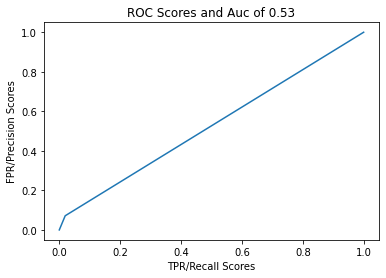

In [29]:
def roc (true_r, pred):
    fp, tp, thresholds = roc_curve(true_r, pred)
    auc_ = auc(fp, tp)
    plt.plot(fp, tp, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(auc_, 2)))
    plt.show()
roc(true_r, pred)

## *3.1* Top 5 recommendations based on user habits and ratings data


In [30]:
user_count = df_interaction[["user","item"]].groupby("user").count()
usercount = user_count[user_count["item"] >= 5] #users with item interactions >=5
item_count = df_interaction[["user","item"]].groupby("item").count() #items with user interactions >=5
itemcount = item_count[item_count["user"] >= 5]

In [31]:
df_updated = df_interaction[df_interaction["user"].isin(usercount.index)\
                            & df_interaction["item"].isin(itemcount.index)]

In [32]:
df = Dataset.load_from_df(df_updated[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()
trainset = df.build_full_trainset()
model.fit(trainset)

In [33]:
reviewmatrix = df_updated.pivot(index="user", columns="item", values="rating").fillna(0) #imputated with 0

In [34]:
def get_rec(user,n):
  '''
  Overview: Function to get top n recommendations based on the rating predictions.
  Working: The function takes a user as input and iterates through all the items in the 
           matrix which the user has not rated.
  Return: Top n predictions are returned.
  '''
  rated = []
  for i in reviewmatrix.columns:
    #print(i)
    if reviewmatrix.loc[user][i] != 0.0:
      rated.append(i)  
    if reviewmatrix.loc[user][i]==0:
      pred = model.predict(uid=user, iid=i)
      #print(pred)
      reviewmatrix.loc[user][i] = pred.est
  recommendations = pd.DataFrame(reviewmatrix.loc[user].sort_values(axis=0,ascending=False))
  recommendations.drop(index=rated, axis=0, inplace=True)
  #print(recommendations.columns)
  top_rec = recommendations.head(n)
  for index,i in top_rec.iterrows():
    #print(index)
    disp_img(list(items_df[items_df['item']==index]['img'])[0],items_df[items_df['item']==index]['title'])
    print('Predicted Rating:', i)

      
  return recommendations.head(n)


In [35]:
#define the input user
input = 'A00404823GU1Q517KP4Z8'
df_user = df_updated[df_updated['user']=='A00404823GU1Q517KP4Z8']

35638    Softwalk Women's Sandee Slip-On Loafer
Name: title, dtype: object


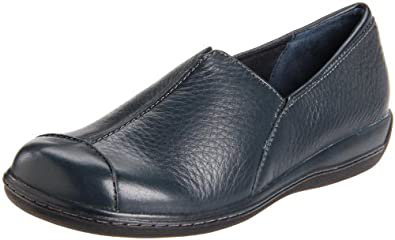

3.0
12617    Jambu Women's Quest Flat,Sand,7.5 M US
Name: title, dtype: object


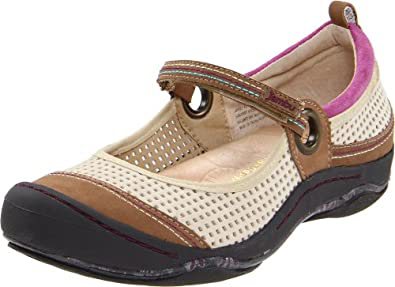

4.0
25255    Clarks Women's Chateau Manor II Ballet Flat
Name: title, dtype: object


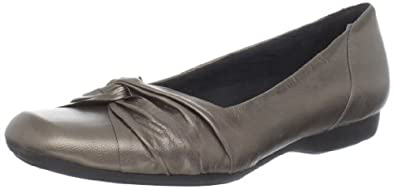

4.0
84462    Easy Spirit Women's Cloverly Sandal
Name: title, dtype: object


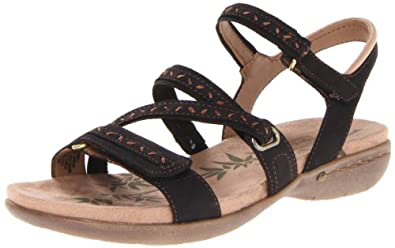

4.0


In [36]:
#iterate through all the items which the user has already bought/rated
for index,i in df_user.iterrows():
  #print(index)
  disp_img(list(items_df[items_df['item']==i['item']]['img'])[0],items_df[items_df['item']==i['item']]['title'])
  print(i['rating'])

3663    Clarks Women's Leisa Taffy Sandal
Name: title, dtype: object


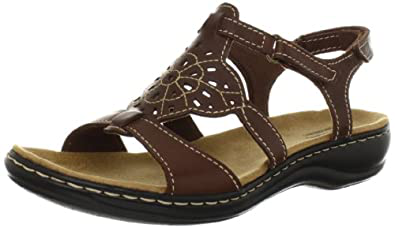

Predicted Rating: A00404823GU1Q517KP4Z8    4.752408
Name: B008OMV0OQ, dtype: float64
6597    Columbia Women's Fast Trek Ii Full Zip Fleece ...
Name: title, dtype: object


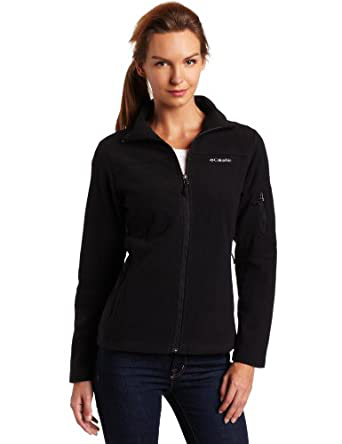

Predicted Rating: A00404823GU1Q517KP4Z8    4.723019
Name: B004XFGE1C, dtype: float64
6139    KEEN Women's Toyah Fashion Sneaker
Name: title, dtype: object


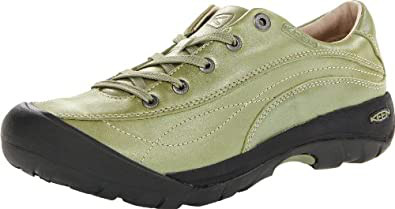

Predicted Rating: A00404823GU1Q517KP4Z8    4.686386
Name: B0036P46JM, dtype: float64
19367    PattyBoutik Ruched V Neck Crossover Faux Wrap ...
Name: title, dtype: object


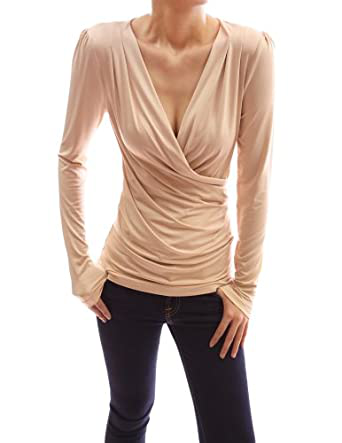

Predicted Rating: A00404823GU1Q517KP4Z8    4.67766
Name: B00F3WDPKW, dtype: float64
663    Skechers Women's Rumblers-Home Run Wedge Sandal
Name: title, dtype: object


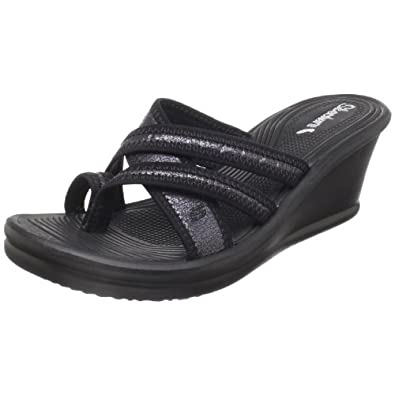

Predicted Rating: A00404823GU1Q517KP4Z8    4.655363
Name: B0036XNGY0, dtype: float64


,A00404823GU1Q517KP4Z8
item,
B008OMV0OQ,4.752408
B004XFGE1C,4.723019
B0036P46JM,4.686386
B00F3WDPKW,4.677660
B0036XNGY0,4.655363


In [37]:
#view the top n recommended items for the user
get_rec('A00404823GU1Q517KP4Z8',5)

## 3.2 Examining Model on Beyond Metrics

* We explore Diversity and Hit Rate as two additional Metrics to determine the rating diversity

In [38]:
del vh
del u

In [39]:
np.random.seed(42)

In [40]:
#get users and items with atleast 10 interaction to not overwhelm the hardware
user_count = df_interaction[["user","item"]].groupby("user").count()
usercount = user_count[user_count["item"] >= 10]
item_count = df_interaction[["user","item"]].groupby("item").count()
itemcount = item_count[item_count["user"] >= 10]
df_updated = df_interaction[df_interaction["user"].isin(usercount.index) & df_interaction["item"].isin(itemcount.index)]

In [41]:
#training
df = Dataset.load_from_df(df_updated[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()

In [42]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def GetTopN(predictions, n, minimumRating=2.7):
  '''The function fetches the top N recommendations for a user given a minimum rating threshold'''
  topN = defaultdict(list)
  for user, item, actualRating, estimatedRating, _ in predictions:
    if (estimatedRating >= minimumRating):
      topN[user].append((item, estimatedRating))

  for user, ratings in topN.items():
    ratings.sort(key=lambda x: x[1], reverse=True)
    topN[user] = ratings[:n]
  return topN

In [43]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
'''
Leave one example from the training set.
We use that example for measuring our hit rate.
'''
LOO = LeaveOneOut(n_splits=1, random_state=42)
from collections import defaultdict
for trainSet, testSet in LOO.split(df):
    # Train model without left-out ratings
    model.fit(trainSet)
    # Predicts ratings for left-out ratings only
    leftOutPredictions = model.test(testSet)
    # Build predictions for all ratings not in the training set
    TestSet = trainSet.build_anti_testset()
    Predictions = model.test(TestSet)
    # Compute top 5 recs for each user
    topNPredicted = GetTopN(Predictions, n=3)

In [44]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def HitRate(topNPredicted, leftOutPredictions):
  '''Function to measure the hit rate.
  Working: Given N recommendation, check if the left out example 
  made it to the list
  '''
  hits = 0
  n = 0
 # For each left-out rating
  for i in leftOutPredictions:
    user = i[0]
    leftoutitem = i[1]
    hit = False
    for item, predictedRating in topNPredicted[user]:
      if (leftoutitem) == item:
        hit = True
        break
    if (hit) :
        hits += 1
    n += 1
  return hits/n
print("\nHit Rate: ", HitRate(topNPredicted, leftOutPredictions))


Hit Rate:  0.0033136094674556214


In [45]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def Diversity(topN,simslgo):
    '''Function to determine the diversity of the recommendation
    Working: Each recommended is compared against each other to determine their similarity.
    return 1-total similarity
    '''
    n = 0#measure total items
    similarity = 0 #measures the totalsimilarity between items
    simMat = simsAlgo.compute_similarities()
    for userId in topN.keys():
        pairs = itertools.combinations(topN[userId],2) #get combinations of two items for comparison
        for pair in pairs:
            item1 = pair[0][0]
            item2 = pair[1][0]
            id1 = simsAlgo.trainset.to_inner_iid(str(item1)) #get the index of the item
            id2 = simsAlgo.trainset.to_inner_iid(str(item2))
            similarity += simMat[id1][id2] #measure similarity between the item
            n += 1
    return 1 - (similarity / n)

In [46]:
sim_options = {'name': 'cosine', 'user_based': False}
simsAlgo = KNNBaseline(sim_options=sim_options) #using simple collaborative model to fetch user-item similarity
trainfull = df.build_full_trainset()
simsAlgo.fit(trainfull)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [47]:
Diversity(topNPredicted,simsAlgo)

Computing the cosine similarity matrix...
Done computing similarity matrix.


0.9295195160222369